<h1>Homework Session 16</h1>



Hipotesis : 
- H0 : Tidak ada peningkatan conversion rate setelah menggunakan tampilan baru
- H1 : Peningkatan pada conversion rate setelah menggunakan tampilan baru

<h2>Data Preparation</h2>

Tahap pertama, yang mana kita menyiapkan data untuk melanjutkan ke tahap selanjutnya.<br>
Berikut adalah penjelasan dari masing-masing kolom yang ada :

Columns:

- user_id : User ID dari setiap session
- timestamp : Timestamp dari setiap id
- group : Mendefinisikan user id kedalam control atau treatment
- landing_page: Mendefinisikan tampilan laman yang dilihat oleh user
- converted : Mengindikasikan apakah terdapat konversi setelah akses ke halaman tersebut (binary, 0 = not converted, 1 = converted)

Groups:
- control group - Mendapatkan tampilan lama
- treatment group - Mendapatkan tampilan terbaru

Conversion Rate:
- 0 : User tidak membeli produk
- 1 : User membeli produk

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import scipy.stats as ss
import math as mt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil

%matplotlib inline

In [ ]:
#Pengambilan Data
data = pd.read_csv('ab_data.csv')
df = data.copy()
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
#Check column yang ada
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<h2>Data Cleaning

In [ ]:
#Lihat unique value
#Terdapat perbedaan total antara user_id dan timestamp. artinya masih ada user_id yang duplicate
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [ ]:
#Melakukan filtering terhadap database
#Drop user_id treatment yang mendapatkan landing page lama
i = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index
df2 = df.drop(i)
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [ ]:
#Check user id yang terduplicate
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [ ]:
#Pengecekan lebih dalam mengenai user id yang duplicate
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [ ]:
#Drop user id yang duplicate, karena nilai konversi dari kedua row sama
df2.drop_duplicates(subset ='user_id',keep ='first',inplace = True)
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [ ]:
# Melakukan perhitungan berdasarkan group
df2.groupby(['group'])['user_id'].count()

group
control      145274
treatment    145310
Name: user_id, dtype: int64

<b>Probability

Pada tahap ini, kita mencoba untuk menghitung kemungkinan dari konversi berdasarkan dengan rata-rata.

In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_s = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_s = ceil(required_s)
required_s

4720

In [ ]:
#Rata-rata secara keseluruhan
P_pool = (df2.query('converted == 1').converted.count())/df2.shape[0]
P_pool

0.11959708724499628

In [ ]:
#Rata-rata konversi dari group control:
control_df = df2.query('group =="control"')
P_old = control_df['converted'].mean()
P_old

0.1203863045004612

In [ ]:
#Rata-rata konversi dari group treatment:
treatment_df = df2.query('group =="treatment"')
P_new = treatment_df['converted'].mean()
P_new

0.11880806551510564

<h2>Visualisasi

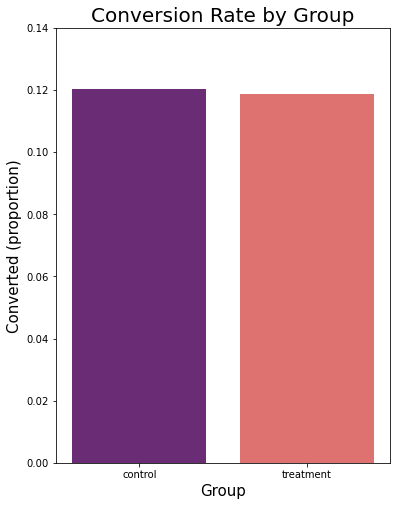

In [ ]:
plt.figure(figsize=(6,8))

sns.barplot(x=df2['group'], y=df2['converted'], ci=False, palette='magma')

plt.ylim(0, 0.14)
plt.title('Conversion Rate by Group', size=20)
plt.xlabel('Group', size=15)
plt.ylabel('Converted (proportion)', size=15);

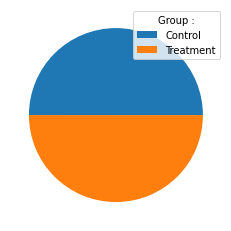

In [ ]:
mylabels = ["Control", "Treatment"]
tes = df2.groupby(['group'])['user_id'].count()
plt.pie(tes)
plt.legend(mylabels, title = "Group :")


<h2>Pengecekan Hasil

In [ ]:
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

In [ ]:
nr_control = control_results.count()
nr_treatment = control_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nr_obs = [nr_control, nr_treatment]

In [ ]:
z_stat, pvalue = proportions_ztest(successes, nobs=nr_obs)

# Confidence interval
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes, nobs=nr_obs, alpha=0.05)

In [ ]:
print('Z Statistic              : {:.2f}'.format(z_stat))
print('P-Value                  : {:6.3f}'.format(pvalue))
print('CI 95% for control group : [{:.3f},{:.3f}]'.format(lower_control, upper_control))
print('CI 95% for Treatment group : [{:.3f},{:.3f}]'.format(lower_treatment, upper_treatment))

Z Statistic              : 1.19
P-Value                  :  0.235
CI 95% for control group : [0.119,0.122]
CI 95% for Treatment group : [0.117,0.121]


Kesimpulan : 
- Nilai P Value lebih tinggi dari alpha, yang berarti peluang menerima h0 lebih besar.
- H0 dari masing-masing pengecekan lebih besar dari pada H1.
- Berdasarkan rata-rata kemungkinan konversi dari user dari group control dan treatment, H0 memiliki konversi lebih tinggi.
- Dengan point-point sebelumnya, dapat disimpulkan bahwa perubahan ke tampilan baru tidak menambah konversi, dan cenderung tidak ada perubahan. Dengan demikian, disarankan untuk tetap menggunakan tampilan lama dan melakukan experiment ulang dengan tampilan yang baru.

Referensi : 
- https://www.kaggle.com/code/aylinkarl/a-b-testing-analysis
- https://www.kaggle.com/code/myzziah/e-commerce-a-b-testing-full-experiment
- https://www.kaggle.com/code/kvinassenza/a-b-testing